# XGBoost for Tabular Regression: How to run inference on the endpoint you have created?

## Import libraries

In [3]:
import json
import boto3
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## The test data to run on endpoint

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output a numerical value.
Throughout the notebook, the examples are taken from the [ABALONE](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) test set. 
The dataset contains examples of eight physical measurements such as length, diameter, and height to predict the age of abalone.

Citations:

- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

In [6]:
# Download the data from s3 buckets
s3 = boto3.client("s3")
data_bucket = 'sagemaker-us-east-1-359953057718'

data_path = "test.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'Jump-start-demo/test/test.csv', data_path)

In [7]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

# read the data
test_data = pd.read_csv(data_path, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the test data: {unbold}")  # Feature_1 is the categorical variables and rest of other features are numeric variables.
test_data.head(5)

The test dataset contains 150 examples and 8 columns.

The first 5 observations of the test data: 


,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7
0,0.71,300.0,104.0,3.0,3.5,3.0,8.16,0.0
1,0.52,325.0,111.0,3.0,3.0,3.5,8.70,0.0
2,0.56,303.0,98.0,1.0,2.0,2.5,7.65,0.0
3,0.65,317.0,103.0,2.0,2.5,2.0,8.15,0.0
4,0.71,310.0,105.0,2.0,3.0,3.5,8.01,0.0


## Query endpoint that you have created

The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, ).

In [8]:
content_type = "text/csv"
def query_endpoint(encoded_tabular_data):
    endpoint_name = 'jumpstart-ftc-xgb-regression-model-1'
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data)
    return response

def parse_resonse(query_response): 
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions['prediction'])


try:
    query_response = query_endpoint(features.to_csv(header=False, index=False).encode("utf-8"))
except Exception as e:
    if e.response is not None and 'Error' in e.response and e.response.get('Error').get('Code') == 'ModelError':
        raise Exception(
             "Backend scripts have been updated in February '22 to standardize response "
             "format of endpoint response."
             "Previous endpoints may not support verbose response type used in this notebook."
             f"To use this notebook, please launch the endpoint again. Error: {e}."
        )
    else:
        raise

try:
    model_predictions = parse_resonse(query_response)
except (TypeError, KeyError) as e:
    raise Exception(
          "Backend scripts have been updated in February '22 to standardize response "
          "format of endpoint response."
           "Response from previous endpoints may not be consistent with this notebook."
           f"To use this notebook, please launch the endpoint again. Error: {e}."
   )

## Evaluate the predictions results returned from the endpoint

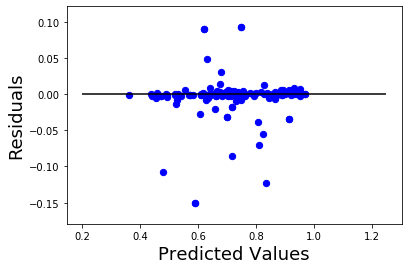

In [13]:
# Visualization: a residual plot to compare the model predictions and ground truth targets. For each example, the residual value 
# is the subtraction between the prediction and ground truth target. 
# We can see that the points in the residual plot are randomly dispersed around the horizontal axis y = 0, 
# which indicates the fitted regression model is appropriate for the ABALONE data

residuals =  ground_truth_label.values[:, 0] - model_predictions
plt.scatter(model_predictions, residuals, color="blue", s=40)
plt.hlines(y=0, xmin=0.2, xmax=1.25)
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.show()

In [10]:
# Evaluate the model predictions quantitatively.
eval_r2_score = r2_score(ground_truth_label.values, model_predictions)
eval_mse_score = mean_squared_error(ground_truth_label.values, model_predictions)
eval_mae_score = mean_absolute_error(ground_truth_label.values, model_predictions)
print (
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{r2_score.__name__}{unbold}: {eval_r2_score}{newline}"
    f"{bold}{mean_squared_error.__name__}{unbold}: {eval_mse_score}{newline}"
    f"{bold}{mean_absolute_error.__name__}{unbold}: {eval_mae_score}{newline}"
)

Evaluation result on test data:
r2_score: 0.9557161949003675
mean_squared_error: 0.0008903605413045446
mean_absolute_error: 0.011734435749053957

